# Analysis of a nonlinear and a linear version of a global carbon cycle model

In this notebook we take the simple global carbon cycle model introduced by Rodhe and Björkström (1979). This model consists of the three compartments atmosphere (A), terrestrial biosphere (T), and surface ocean (S). The model is considered in equilibrium in the year 1765 when only a constant flux of carbon enters the model coming from the deep ocean (outside the model) to the surface ocean (S).

After the year 1765 an additional time-dependent influx comes to the atmosphere through combustion of fossil fuels. We look at the transit-time and age distributions of the model in two versions. The model depends on two parameters $\alpha$ and $\beta$. We look at the original parameter set (1) $(\alpha, \beta) = (0.2, 10.0)$ and (2) $(\alpha, \beta) = (1,1)$. Version (1) is the originally published version and leads to a nonlinear behavior of the model. Version (2) is used as a reference model and leads to a linear behavior.


We import all necessary packages. The package [LAPM](https://github.com/MPIBGC-TEE/LAPM) treats transit-time and age densities for **L**inear **A**utonomous **P**ool **M**odels and is needed to compute the steady-state age distributions which are is used as initial age distributions in the year 1765. Then we use the [CompartmentalSystems](https://github.com/MPIBGC-TEE/CompartmentalSystems) package to compute how the age distributions change in time when the system is perturbed by the addition of fossil-fuel derived carbon to the atmosphere.

In [1]:
# file system operations
import os

# all array-like data structures are numpy.array
import numpy as np

# for 2d plots we use Matplotlib
import matplotlib.pyplot as plt

# for 3d plots we use plotly
# load plotly's jupyter notebook functions
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)

# symbolic treatment of reservoir models as basis of model runs
from sympy import Matrix, symbols, Symbol, Function, latex

# the input function of carbon to the atmosphere is going to be
# a linearly interpolated function of a data set
from scipy.interpolate import interp1d

# load the compartmental model packages
from LAPM.linear_autonomous_pool_model import LinearAutonomousPoolModel
from CompartmentalSystems.smooth_reservoir_model import SmoothReservoirModel
from CompartmentalSystems.smooth_model_run import SmoothModelRun

## technical part for notebook ##

# enable latex in plotly labels
from IPython.display import display, HTML, Markdown
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

We check whether the `output_data` folder exists and create it if not. In general, all data will be loaded from existing files in this folder. If the according file does not exist, a new computation is going to be started and afterwards the data is going to be saved in in this folder.

To enforce a complete new computation of all data, simply delete the `output_data` folder. Such a new computation might take a day or more, depending on the CPU speed. In particular brute force quantile computations (of backward transit times) are time consuming.

In [2]:
versions = np.array([1,2]) # 1 = nonlinear, 2 = linear
title_suffs  = [' (nonlinear)', ' (linear)']

folders = []
for version in versions:
    folder = 'output_data_v%d/' % version
    folders.append(folder)

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print("Created output data folder named '%s'" % folder)

versions = versions - 1 # internal use of the indices 0, 1; except for folders
    

Next, we initialize the symbols we need to represent the model.

In [3]:
########## symbol definitions ##########

# time symbol
time_symbol = symbols('t')

# Atmosphere, Terrestrial Carbon and Surface ocean
C_A, C_T, C_S = symbols('C_A C_T C_S')

# fossil fuel inputs
u_A = Function('u_A')(time_symbol)

# land use change flux
f_TA = Symbol('f_TA')(time_symbol)

# nonlinear effects
alpha, beta = symbols('alpha beta')

Now, we define the model.

In [4]:
########## model structure: equilibrium values and fluxes ##########

# equilibrium values
A_eq, T_eq, S_eq = (700.0, 3000.0, 1000.0)

state_vector = Matrix([C_A, C_T, C_S])

# fluxes
F_AT = 60*(C_A/A_eq)**alpha
F_AS = 100*C_A/A_eq
F_TA = 60*C_T/T_eq + f_TA
F_SA = 100*(C_S/S_eq)**beta

input_fluxes = {0: u_A, 1: 0, 2: 45} 
output_fluxes = {2: 45*C_S/S_eq}
internal_fluxes = {(0,1): F_AT, (0,2): F_AS,
                   (1,0): F_TA, (2,0): F_SA}

# create the SmoothReservoirModel
nonlinear_srm = SmoothReservoirModel(state_vector, 
                                     time_symbol, 
                                     input_fluxes, 
                                     output_fluxes, 
                                     internal_fluxes)

# define the time and age windows of interest
start_year = 1765
end_year = 2500
max_age = 250

times = np.arange(start_year, end_year+1, 1)
ages = np.arange(0, max_age+1, 1)


We read in the fossil fuel inputs and the land use change effects from a csv file and create linear interpolation functions from the data points. Then we connect these function with the symbols from the model.

In [5]:
# fossil fuel and land use change data
ff_and_lu_data = np.loadtxt('emissions.csv', usecols = (0,1,2), skiprows = 38)

# column 0: time, column 1: fossil fuels
ff_data = ff_and_lu_data[:,[0,1]]

# linear interpolation of the (nonnegative) data points
u_A_interp = interp1d(ff_data[:,0], np.maximum(ff_data[:,1], 0))

def u_A_func(t_val):
    # here we could do whatever we want to compute the input function
    # we return only the linear interpolation from above
    return u_A_interp(t_val)

# column 0: time, column 2: land use effects
lu_data = ff_and_lu_data[:,[0,2]]
f_TA_func = interp1d(lu_data[:,0], lu_data[:,1])

# define a dictionary to connect the symbols with the according functions
func_set = {u_A: u_A_func, f_TA: f_TA_func}

We can plot the functions created by linear interpolation of external data.

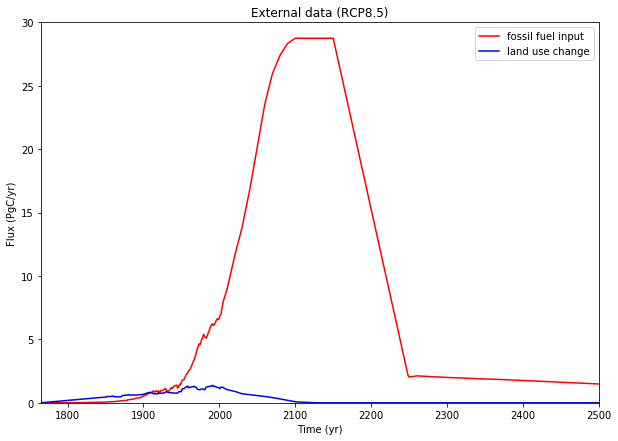

In [6]:
# plot the functions based on external data sets
plt.figure(figsize=(10,7))
plt.title('External data (RCP8.5)')
plt.plot(times, [u_A_func(t) for t in times], color='red', label='fossil fuel input')
plt.plot(times, [f_TA_func(t) for t in times], color='blue', label='land use change')
plt.xlim([1765,2500])
plt.ylim([0,30])
plt.legend(loc=1)
plt.xlabel('Time (yr)')
plt.ylabel('Flux (PgC/yr)')
plt.show()

We use the `SmoothReservoirModel`, the parameter dictionary, and the customly defined functions to create a `SmoothModelRun`. First for the version 1, then for version 2.

In [7]:
# the system starts in equilibrium
start_values = np.array([A_eq, T_eq, S_eq])

# possibly nonlinear effects as a parameter dictionary
par_dict_v1 = {alpha: 0.2, beta: 10.0} # nonlinear
par_dict_v2 = {alpha: 1.0, beta:  1.0} # linear
par_dicts = [par_dict_v1, par_dict_v2]

# create the nonlinear model run
nonlinear_smrs = []
for version in versions:
    nonlinear_smr = SmoothModelRun(nonlinear_srm, par_dicts[version], start_values, times, func_set)
    nonlinear_smrs.append(nonlinear_smr)

# create a linear model with the same solution trajectory
smrs = []
for version in versions:
    smr = nonlinear_smrs[version].linearize()
    smrs.append(smr)

Now, we compute the state transition operator cache and save it to a file. If this file already exists, we simply load it instead of having to recompute it. Depending on the size of the state stransition operator cache, this might take several hours. But all time we invest at this point will be saved later on during density and quantile computations.

Furthermore, we solve the linearized model and plot the solution trajectories for the different compartments.

Loading state transition operator
done
Loading state transition operator
done


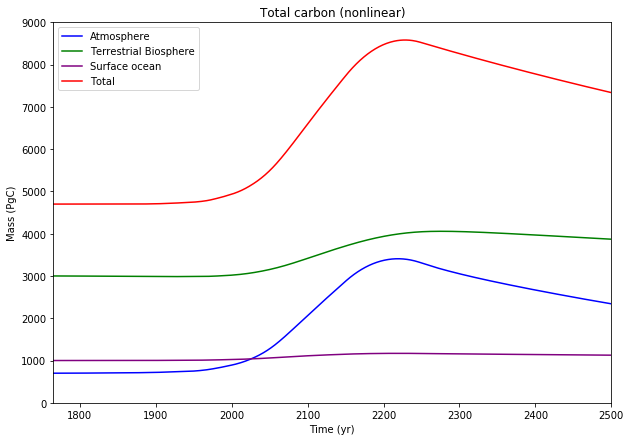

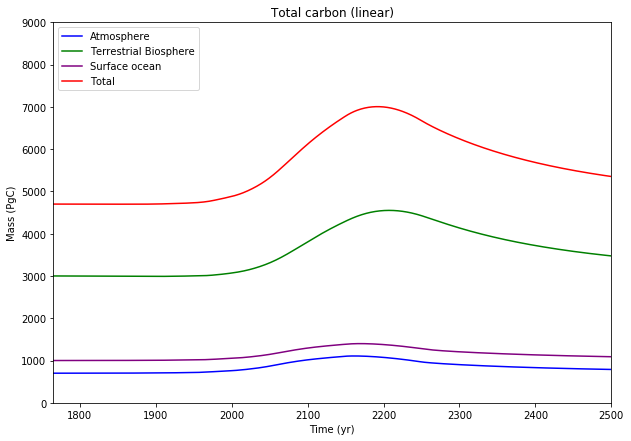

In [8]:
##### (build and save or) load state transition operator cache #####

# the cache size indicates at how many intermediate time points the
# state transition operator is going to be cached to increase
# the speed of upcoming computations massively
cache_size = 1001

for version in versions:
    try:
        print('Loading state transition operator')
        smrs[version].load_state_transition_operator_cache(folders[version] + '_sto.cache')
    except FileNotFoundError:
        print('Building state transition operator cache')
        smrs[version].build_state_transition_operator_cache(size = cache_size)
        print('Saving state transition operator cache')
        smrs[versions].save_state_transition_operator_cache(folders[version] + '_sto.cache')
    print('done')

# solve the equivalent linear model
for version in versions:
    soln = smrs[version].solve()

    # plot the solution
    plt.figure(figsize=(10,7))
    plt.title('Total carbon'+title_suffs[version])
    plt.plot(times, soln[:,0], color='blue', label='Atmosphere')
    plt.plot(times, soln[:,1], color='green', label='Terrestrial Biosphere')
    plt.plot(times, soln[:,2], color='purple', label='Surface ocean')
    plt.plot(times, soln.sum(1), color='red', label='Total')
    plt.xlim([1765,2500])
    plt.ylim([0,9000])
    plt.legend(loc=2)
    plt.xlabel('Time (yr)')
    plt.ylabel('Mass (PgC)')
    plt.show()

We now use the `LAPM` package to compute the initial age densities and the initial mean age under the assumption that the system is in steady state in the year 1765.

In [9]:
##### load linear autonomous pool model in steady state #####

# rhs = xi*T*N*C + u
xi, T, N, C, u = nonlinear_srm.xi_T_N_u_representation

# B = xi*T*N, plug in the steady-state initial contents
# no land use change flux
B = (xi*T*N).subs(par_dicts[0]).subs({C_A: A_eq, C_T: T_eq, C_S: S_eq, f_TA: 0}) # version does not matter here

# no fossil fuel inputs
u = u.subs(par_dicts[0]).subs({u_A: 0})

# force purely numerical treatment of the LAPM
# symbolic treatment would be too slow here
LM = LinearAutonomousPoolModel(u, B, force_numerical=True)

## load equilibrium age densities ##

# the start age densities are given as a function of age that returns
# a vector of mass with that age
def start_age_densities(a):
    # we need to convert from sympy data types to numpy data types
    res =  np.array(LM.a_density(a)).astype(np.float64).reshape((3,)) * start_values
    return res

# get the start mean ages
start_mean_ages = np.array(LM.a_expected_value).astype(np.float64).reshape((3,))
start_age_moments = start_mean_ages.reshape((1,3))

print(B)

Matrix([[-0.228571428571429, 0.0200000000000000, 0.100000000000000], [0.0857142857142857, -0.0200000000000000, 0], [0.142857142857143, 0, -0.145000000000000]])


We can now plot the initial age distributions. These are the equilibrium age densities in the year 1765.

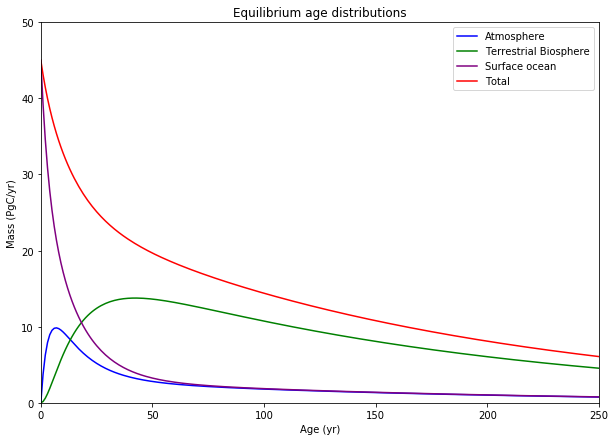

In [10]:
plt.figure(figsize=(10,7))
plt.title('Equilibrium age distributions')
y = np.array([start_age_densities(a) for a in ages])
plt.plot(ages, y[:,0], color='blue', label='Atmosphere')
plt.plot(ages, y[:,1], color='green', label='Terrestrial Biosphere')
plt.plot(ages, y[:,2], color='purple', label='Surface ocean')
plt.plot(ages, y.sum(1), color='red', label='Total')
plt.legend()
plt.xlabel('Age (yr)')
plt.ylabel('Mass (PgC/yr)')
plt.xlim([0, 250])
plt.ylim([0, 50])
plt.show()

Now, we compute the age densities of the system that is perturbed by fossil fuel input and land use change.
We further create according figure objects to which we will later add also a transparent equilibrium surface and mean and median lines.

In [11]:
age_densitiess = []
pool_age_densitiess = []
system_age_densities = []

for version in versions:
    try:
        print('Loading age densities')
        age_densities = smrs[version].load_pools_and_system_densities_csv(folders[version] + 'age_dens.csv', ages)
        age_densitiess.append(age_densities)
        
        pool_age_densities = age_densities[:,:,:smrs[version].nr_pools]
        pool_age_densitiess.append(pool_age_densities)
        
        system_age_density = age_densities[:,:,smrs[version].nr_pools]
        system_age_densities.append(system_age_density)
        
    except FileNotFoundError:
        print('Computing age densities')
        p = smr[version].pool_age_densities_func(start_age_densities)
        pool_age_densities = p(ages)
        pool_age_densitiess.append(pool_age_densities)
        
        system_age_density = smr[version].system_age_density(pool_age_densities)
        system_age_densities.append(system_age_density)
    
        print('Saving age densities')
        smr[version].save_pools_and_system_density_csv(folders[version] + 'age_dens.csv', pool_age_densities, system_age_density, ages)
    
        # combine pool and system age densities to one numpy array
        age_densities = smr_v1.age_densities(pool_age_densities, system_age_density)
        age_densitiess.append(age_densities)
        
    print('done')
    
# plotting coarsity in age and time direction for saving memory
age_stride = 10
time_stride = 10

pools = range(smrs[0].nr_pools)
# create the figures of the compartment and system age densities
figs = []
titles = ["$" + latex(smrs[0].model.state_vector[pool]) for pool in pools] + ["$\\text{Total}"]

figversions = []
poolnumbers = []
for k in range(smrs[version].nr_pools+1):
    for version in versions:
        print(title_suffs[version])
        fig = smrs[version].plot_3d_density_plotly(titles[k]+"\\text{"+title_suffs[version]+"}$", 
                                         age_densitiess[version][:,:,k], 
                                         ages, 
                                         age_stride=age_stride,
                                         time_stride=time_stride)

            
        figs.append(fig)
        figversions.append(version)
        poolnumbers.append(k)

Loading age densities
done
Loading age densities
done
 (nonlinear)
 (linear)
 (nonlinear)
 (linear)
 (nonlinear)
 (linear)
 (nonlinear)
 (linear)


Let us add transparent equilibrium surfaces to the density plots.

In [12]:
for nr, fig in enumerate(figs):
    version = figversions[nr]
    smrs[version].add_equilibrium_surface_plotly(fig, opacity=0.7)

We also compute the mean ages and the age medians for the different compartments and the system.

In [13]:
##### mean ages #####

pool_age_means = []
system_age_means = []
for version in versions:
    try:
        print('Loading mean ages')
        pool_age_mean, system_age_mean = smrs[version].load_pools_and_system_value_csv(folders[version] + 'age_mean.csv')

    except FileNotFoundError:
        print('Computing mean ages')
        pool_age_mean = smrs[version].age_moment_vector(1, start_age_moments)
        system_age_mean = smrs[version].system_age_moment(1, start_age_moments)
    
        print('Saving mean ages')
        smrs[version].save_pools_and_system_value_csv(folders[version] + 'age_mean.csv', pool_age_mean, system_age_mean)

    pool_age_means.append(pool_age_mean)
    system_age_means.append(system_age_mean)
    print('done')

##### age medians #####

# set a tolerance for the quantile precision
# the smaller the more precise and the slower
tol = 1e-1

# start cumulative mass functions of age
# to have it available allows faster computations,
# since we save tedious numerical integrations
def F0(a):
    res = np.array(LM.a_cum_dist_func(a)).astype(np.float64).reshape((3,)) * start_values
    return res

pool_age_medians = []
system_age_medians = []
for version in versions:
    try:
        print('Loading age medians')
        pool_age_median, system_age_median = smrs[version].load_pools_and_system_value_csv(folders[version] + 'age_median.csv')

    
    except FileNotFoundError:
        print('Computing age medians')
        pool_age_median = smrs[version].pool_age_distributions_quantiles_by_ode(0.5, start_age_densities=start_age_densities, F0=F0, tol=tol)
        system_age_median = smrs[version].system_age_distribution_quantiles_by_ode(0.5, start_age_densities=start_age_densities, F0=F0, tol=tol)
        
        print('Saving age medians')
        smrs[version].save_pools_and_system_value_csv(folders[version] + 'age_median.csv', pool_age_median, system_age_median)

    pool_age_medians.append(pool_age_median)
    system_age_medians.append(system_age_median)
    
    print('done')


Loading mean ages
done
Loading mean ages
done
Loading age medians
done
Loading age medians
done


We add the mean and the median lines to the density plots and finally execute the plots.
The third figure for each pool is always the difference betwwen the previous two.

In [14]:
# combine pool and system mean ages and age medians
age_means = []
age_medians = []
for version in versions:
    age_mean = smrs[version].combine_pools_and_system_values(pool_age_means[version], system_age_means[version])
    age_means.append(age_mean)
    
    age_median = smrs[version].combine_pools_and_system_values(pool_age_medians[version], system_age_medians[version])
    age_medians.append(age_median)
    
# add mean and median lines to the figures
def add_mean_and_median_lines_to_figure(smr, fig, mean = None, median = None, mean_title = None, median_title = None, index = 0):
    # mean age lines
    if mean is not None:
        smr.add_line_to_density_plot_plotly(fig, mean, '#0000FF', mean_title, 
                                            time_stride=time_stride,
                                            on_surface=True,
                                            bottom=True,
                                            legend_on_surface=True,
                                            legend_bottom=False
                                            )

        # equilibrium mean age line
        values = mean[index] * np.ones_like(times)
        smr.add_line_to_density_plot_plotly(fig, values, '#CCCCCC', 'equilibrium', 
                                            time_stride=time_stride,
                                            on_surface=False,
                                            bottom=True,
                                            legend_bottom=False
                                            )
        
    # age median lines
    if median is not None:
        smr.add_line_to_density_plot_plotly(fig, median, '#FF0000', median_title, 
                                            time_stride=time_stride,
                                            on_surface=True,
                                            bottom=True,
                                            legend_on_surface=True,
                                            legend_bottom=False
                                            )
    
        # equilibrium age median line
        values = median[index] * np.ones_like(times)
        smr.add_line_to_density_plot_plotly(fig, values, '#CCCCCC', 'equilibrium', 
                                            time_stride=time_stride,
                                            on_surface=False,
                                            bottom=True,
                                            legend_bottom=True
                                            )
            
for nr, fig in enumerate(figs):
    version = figversions[nr]
    pool_nr = poolnumbers[nr]
    add_mean_and_median_lines_to_figure(smrs[version], fig, age_means[version][:,pool_nr], 
                                        age_medians[version][:,pool_nr], 'mean age', 'age median')

In [16]:
# use the same scale for the same pool
z_maxs = [40,30,50,80]
diff_ranges = [[0,40], [-10,5], [-20,5], [0,12]]

# finally plot the figures
for nr, fig in enumerate(figs):
    pool_nr = poolnumbers[nr]
    fig['layout']['legend'] = dict(x=0.8, y=0.8)
    fig['layout']['scene']['zaxis'] = dict(range = [0,z_maxs[pool_nr]])
    iplot(fig)
    
    if nr in [1,3,5,7]:
        # create the difference figure
        age_densities_diff = age_densitiess[0][:,:,pool_nr]-age_densitiess[1][:,:,pool_nr]
        # version irrelevant
        fig = smrs[0].plot_3d_density_plotly(titles[pool_nr]+"\\text{ (difference)}$", 
                                         age_densities_diff, 
                                         ages, 
                                         age_stride=age_stride,
                                         time_stride=time_stride)
        
        fig['layout']['legend'] = dict(x=0.8, y=0.8)
        fig['layout']['scene']['zaxis'] = dict(range = [diff_ranges[pool_nr][0],diff_ranges[pool_nr][1]])
        iplot(fig)
        

In [20]:
s = "In the year 2017, the mean age of carbon in the atmosphere is"
s += " %1.2f yr (linear: %1.2f)" % (age_means[0][2017-1765, 0], age_means[1][2017-1765, 0])
s += " and the median age is equal to"
s += " %1.2f yr (%1.2f)." % (age_medians[0][2017-1765, 0], age_medians[1][2017-1765, 0])
display(Markdown(s))

In the year 2017, the mean age of carbon in the atmosphere is 126.35 yr (linear: 128.31) and the median age is equal to 60.69 yr (62.69).

### Second moments

We can also compute higher order moments of the age distributions. 
To that end, we need to provide initial age moments of the same order.

In [21]:
##### second moment #####

pool_age_moments_2 = []
system_age_moments_2 = []

for version in versions:
    try:
        print('Loading second order age moment')
        pool_age_moment_2, system_age_moment_2 = smrs[version].load_pools_and_system_value_csv(folders[version] + 'age_moment_2.csv')
    except FileNotFoundError:
        print('Computing second order age moment')
        # set up the initial age moments of second order
        start_age_moment_2 = np.array(LM.a_nth_moment(2)).astype(np.float64).reshape((3,))
        start_age_moments = np.array([start_mean_ages, start_age_moment_2])

        # compute the age moment vector of second order
        pool_age_moment_2 = smrs[version].age_moment_vector(2, start_age_moments)
        system_age_moment_2 = smrs[version].system_age_moment(2, start_age_moments)
        smrs[version].save_pools_and_system_value_csv(folders[version] + 'age_moment_2.csv', pool_age_moment_2, system_age_moment_2)

    pool_age_moments_2.append(pool_age_moment_2)
    system_age_moments_2.append(system_age_moment_2)
print('done')

Loading second order age moment
Loading second order age moment
done


In [22]:
s = "The standard deviation of the atmosphere's carbon age in 2017 equals"
s += " %1.2f yr (linear: %1.2f)" % (np.sqrt(pool_age_moments_2[0][2017-1765, 0]-pool_age_means[0][2017-1765, 0]**2), np.sqrt(pool_age_moments_2[1][2017-1765, 0]-pool_age_means[1][2017-1765, 0]**2))
s += " , indicating that the distribution has a long tail."
display(Markdown(s))

The standard deviation of the atmosphere's carbon age in 2017 equals 161.72 yr (linear: 162.92) , indicating that the distribution has a long tail.

In [39]:
smr_v1.save_pools_and_system_value_csv(folder + 'input_flux.csv', smr_v1.external_input_vector, smr_v1.external_input_vector.sum(1))
smr_v1.save_pools_and_system_value_csv(folder + 'output_flux.csv', smr_v1.external_output_vector, smr_v1.external_output_vector.sum(1))

## Subsystem of only fossil fuel derived carbon

We can compute all such densities also for the subsystem that deals only with the fossil-fuel derived carbon.
To that end, we initialize another `SmoothReservoirModel` and `SmoothModelRun`, `srm_ff_only` and `smr_ff_only`, using the original solution trajectory, but changing the input vector `u`.
We suppress the inputs coming from the deep ocean and look only what happens to the fossil-fuel inputs that come directly to the atmosphere. This approach works, since the nonlinear effects that arise from the existence of other particles in the system, are incorporated in the trajectory of the linear system which is equivalent to the nonlinear system. The state transition matrix for the fossil fuel only subsystem is consequently the same as the one for the entire system.

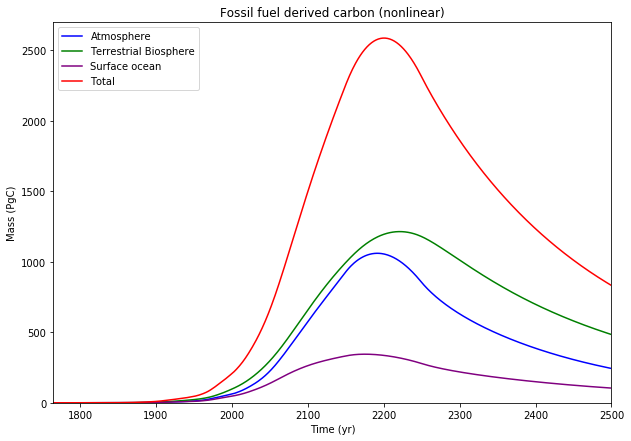

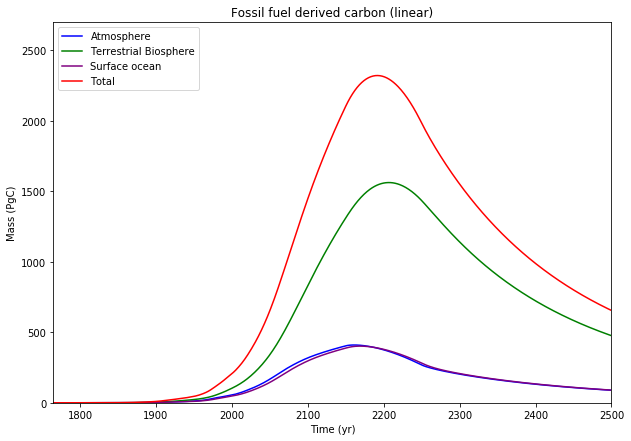

In [25]:
xi, T, N, C, u = smrs[0].model.xi_T_N_u_representation # version does not matter
B = xi*T*N

# consider fossil fuel input only, no deep ocean input
u[2] = 0 

# set up fossil fuel only system
start_values_ff_only = np.zeros((3,)) # no fossil fuels in the system in 1765

srms_ff_only = []
smrs_ff_only = []

for version in versions:
    srm_ff_only = SmoothReservoirModel.from_B_u(state_vector, time_symbol, B, u)
    smr_ff_only = SmoothModelRun(srm_ff_only, smrs[version].parameter_set, start_values_ff_only, smrs[version].times, smrs[version].func_set)

    srms_ff_only.append(srm_ff_only)
    smrs_ff_only.append(smr_ff_only)
    
# the trick is to use the same state transition operator as before
# --> the fossil fuel carbon moves through the system as if all other carbon were there, too
for version in versions:
    smrs_ff_only[version].load_state_transition_operator_cache(folders[version] + '_sto.cache')

solns_ff_only = []
for version in versions:
    soln_ff_only = smrs_ff_only[version].solve()
    solns_ff_only.append(soln_ff_only)

# plot the solutions
for version in versions:
    plt.figure(figsize=(10,7))
    plt.title('Fossil fuel derived carbon'+title_suffs[version])
    plt.plot(times, solns_ff_only[version][:,0], color='blue', label='Atmosphere')
    plt.plot(times, solns_ff_only[version][:,1], color='green', label='Terrestrial Biosphere')
    plt.plot(times, solns_ff_only[version][:,2], color='purple', label='Surface ocean')
    plt.plot(times, solns_ff_only[version].sum(1), color='red', label='Total')
    plt.xlim([1765,2500])
    plt.ylim([0, 2700])
    plt.legend(loc=2)
    plt.xlabel('Time (yr)')
    plt.ylabel('Mass (PgC)')
    plt.show()

### Forward transit time

The forward transit time tells (at the moment of entry) the future age particles will have when they leave the system.
We cannot compute the mean for this quantity, since we do not know the future behavior of the system until eterntity, but only until 2500.
Nevertheless, we could compute the median until a certain point in the future by brute force.

Now, we show the forward transit time densities of fossil fuel carbon that entered the atmosphere in the years 1800, 1990, 2015, 2170, 2300.

In [33]:
###### forward transit time #####

ftt_densities_ff_only = []
for version in versions:
    try:
        print('Loading forward transit time density')
        ftt_density_ff_only = smrs_ff_only[version].load_density_csv(folders[version] + 'ftt_dens_ff_only.csv', ages)
    except FileNotFoundError:
        print('Computing forward transit time density')
        ftt_density_func = smrs_ff_only[version].forward_transit_time_density_func()
        ftt_density_ff_only = ftt_density_func(ages)
        smrs_ff_only[version].save_density_csv(folders[version] + 'ftt_dens_ff_only.csv', ftt_density_ff_only, ages)
        
    ftt_densities_ff_only.append(ftt_density_ff_only)
    print('done')

Loading forward transit time density
done


We can also compute the medians.

In [ ]:
ftt_medians_ff_only = []
for version in versions:
    try:
        print('Loading const_ff forward transit time median')
        ftt_median_ff_only = np.loadtxt(folders[version] + 'ftt_median_ff_only.csv', usecols = (1,), delimiter = ',', skiprows = 1)
    except FileNotFoundError:
        print('Computing ff forward transit time median')
        F_ftt_sv_ff_only = smrs_ff_only[version].cumulative_forward_transit_time_distribution_single_value()
        ftt_median_ff_only = smrs_ff_only[versiion].distribution_quantiles(0.5, 
                                                              F_ftt_sv_ff_only, 
                                                              norm_consts=smrs_ff_only[version].external_input_vector.sum(1), 
                                                              start_values=[110]*len(times), 
                                                              method='brentq', 
                                                              tol=tol)
        print('Saving ff forward transit time median')
        smrs_ff_only[version].save_value_csv(folders[version] + 'ftt_median_ff_only.csv', ftt_median_ff_only)

    ftt_medians_ff_only.append(ftt_median_ff_only)    
    print('done')

We can now cut out the years of interest and see how the forward transit time distribution of fossil fuel carbon changes over time.

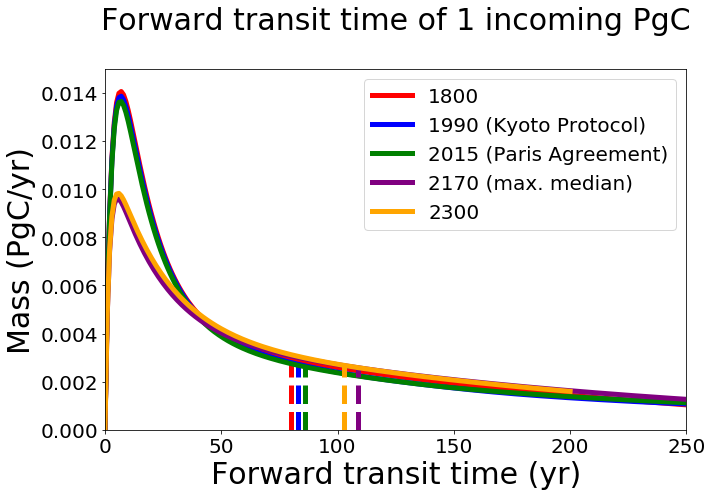

In [60]:
years = [1800, 1990, 2015, 2170, 2300]
labels = ['1800', '1990 (Kyoto Protocol)', '2015 (Paris Agreement)', '2170', '2300']
colors = ['red', 'blue', 'green', 'purple', 'orange']

for version in versions:
    plt.figure(figsize=(10,7))
    plt.title('Forward transit time of fossil fuel carbon'+title_suffs[version])

    for k in range(len(years)):
        year = years[k]
        color = colors[k]
        label = labels[k]
        plt.plot(ages, ftt_densities_ff_only[version][:,year-1765], color=color, label=label)
    
        # add vertical median lines
        median = ftt_medians_ff_only[version][year-1765]
        dens_val = ftt_densities_ff_only[version][int(median),year-1765]
        plt.plot((median, median), (0, dens_val), color = color, ls = '--')

    plt.legend(loc=0)
    plt.xlabel('Forward transit time (yr)')
    plt.ylabel('Mass (PgC/yr)')
    plt.xlim([0, 250])
    plt.ylim([0,0.015])
    plt.show()

In [61]:
s = "The dashed medians for the nonlinear version are given by "
s += ", ".join(["%01.2f yr" % ftt_medians_ff_only[0][year-1765] for year in years]) + "."
display(Markdown(s))

s = "The dashed medians for the linear version are given by "
s += ", ".join(["%01.2f yr" % ftt_medians_ff_only[1][year-1765] for year in years]) + "."
display(Markdown(s))


The dashed medians are given by 79.85 yr, 82.91 yr, 86.12 yr, 108.91 yr, 102.61 yr.